# Libraries 

In [2]:
# import libraries 
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import pytrends 
from pytrends.request import TrendReq
import time
from datetime import datetime, timedelta
import matplotlib.dates as mdates


# Set up pytrends (english language, timezone UTC+6)
pytrends = TrendReq(hl='en-US', tz=360)



In [3]:
# Read both value and volume data from Excel files
value_data = pd.read_excel("E-Commerce Transactions Value.xlsx")
volume_data = pd.read_excel("E-Commerce Transactions Volume.xlsx")

In [4]:
data = pd.merge(value_data, volume_data, on="Date", how="outer")

In [5]:
data.head()

,Date,E-Commerce Transactions: Value,E-Commerce Transactions: Volume
0,2018-12-30,48229.459312,456
1,2018-12-31,68629.143788,559
2,2019-01-01,52162.890120,471
3,2019-01-02,66311.844346,736
4,2019-01-03,95740.128026,682


In [6]:
# rename columns for clarity
data.rename(columns={'E-Commerce Transactions: Value': 'E-Commerce Value', 'E-Commerce Transactions: Volume': 'E-Commerce Volume','Date':'date'}, inplace=True)

In [7]:
data.head()

,date,E-Commerce Value,E-Commerce Volume
0,2018-12-30,48229.459312,456
1,2018-12-31,68629.143788,559
2,2019-01-01,52162.890120,471
3,2019-01-02,66311.844346,736
4,2019-01-03,95740.128026,682


In [9]:
# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])


In [10]:
data

,date,E-Commerce Value,E-Commerce Volume
0,2018-12-30,48229.459312,456
1,2018-12-31,68629.143788,559
2,2019-01-01,52162.890120,471
3,2019-01-02,66311.844346,736
4,2019-01-03,95740.128026,682
...,...,...,...
2360,2025-06-30,28205.582890,629
2361,2025-07-01,29144.454690,624
2362,2025-07-02,40365.723218,1077
2363,2025-07-03,21466.979056,484


In [11]:
data.columns

Index(['date', 'E-Commerce Value', 'E-Commerce Volume'], dtype='object')

In [12]:

data['date'].unique()

<DatetimeArray>
['2018-12-30 00:00:00', '2018-12-31 00:00:00', '2019-01-01 00:00:00',
 '2019-01-02 00:00:00', '2019-01-03 00:00:00', '2019-01-04 00:00:00',
 '2019-01-05 00:00:00', '2019-01-06 00:00:00', '2019-01-07 00:00:00',
 '2019-01-08 00:00:00',
 ...
 '2025-06-24 00:00:00', '2025-06-25 00:00:00', '2025-06-26 00:00:00',
 '2025-06-27 00:00:00', '2025-06-29 00:00:00', '2025-06-30 00:00:00',
 '2025-07-01 00:00:00', '2025-07-02 00:00:00', '2025-07-03 00:00:00',
 '2025-07-04 00:00:00']
Length: 2365, dtype: datetime64[ns]

In [13]:
data.shape

(2365, 3)

# Collecting  daily trends data for the categories

In [14]:

def chunk_list(lst, size=5):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

def daterange_chunks(start_date, end_date, months=6):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    while start < end:
        chunk_end = min(start + pd.DateOffset(months=months), end)
        yield (start.strftime('%Y-%m-%d'), chunk_end.strftime('%Y-%m-%d'))
        start = chunk_end + timedelta(days=1)

def fetch_category_trends(keywords, category_id, category_name='', geo='ZA',
                          timeframe=('2018-12-30', '2025-07-04'), sleep_sec=20,
                          base_dir='trends_data'):

    for (start, end) in daterange_chunks(timeframe[0], timeframe[1]):
        chunk_dataframes = []

        print(f"Fetching from {start} to {end} for {len(keywords)} keywords in category '{category_name}'")

        for keyword_chunk in chunk_list(keywords, size=5):
            try:
                pytrends.build_payload(keyword_chunk, cat=category_id, geo=geo, timeframe=f'{start} {end}')
                df = pytrends.interest_over_time()
                if not df.empty:
                    df = df.drop(columns=['isPartial'], errors='ignore')
                    chunk_dataframes.append(df)
            except Exception as e:
                print(f"Error fetching chunk {keyword_chunk} from {start} to {end}: {e}")
            time.sleep(sleep_sec)

        if chunk_dataframes:
            # Merge keyword chunks horizontally on datetime index
            merged_chunk = pd.concat(chunk_dataframes, axis=1)
            merged_chunk = merged_chunk.loc[:, ~merged_chunk.columns.duplicated()]
            merged_chunk.reset_index(inplace=True)

            # Create folder path
            category_folder = os.path.join(base_dir, category_name.replace('/', '-'))
            os.makedirs(category_folder, exist_ok=True)

            # Generate unique filename per chunk
            filename = f"{category_name.replace('/', '-')}_{start}_to_{end}.csv"
            full_path = os.path.join(category_folder, filename)

            # Save chunk to CSV
            merged_chunk.to_csv(full_path, index=False)
            print(f"Saved chunk to {full_path}")
        else:
            print(f"No data fetched for chunk {start} to {end}")
            


In [ ]:
# Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Get Google Trends categories
categories = pytrends.categories()

# Extract parent categories
parent_categories = []
def extract_parents(cat_dict):
    if 'children' in cat_dict:
        for child in cat_dict['children']:
            parent_categories.append({
                'Category_ID': child.get('id'),
                'Category_Name': child.get('name')
            })
    else:
        for key, value in cat_dict.items():
            if isinstance(value, dict) and 'children' in value:
                for child in value['children']:
                    parent_categories.append({
                        'Category_ID': child.get('id'),
                        'Category_Name': child.get('name')
                    })

extract_parents(categories)

# Convert to DataFrame
df = pd.DataFrame(parent_categories)

# Split into two columns of 12 each
df_left = df.iloc[:12].reset_index(drop=True)
df_right = df.iloc[12:24].reset_index(drop=True)

# Combine into a single table
two_column_df = pd.concat([df_left, df_right], axis=1)
two_column_df.columns = ['Category_ID_1', 'Category_Name_1', 'Category_ID_2', 'Category_Name_2']

# Apply styling with grid and colors
styled_table = two_column_df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), 
                                 ('color', 'white'), 
                                 ('border', '1px solid black'),
                                 ('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid black'),
                                 ('padding', '5px'),
                                 ('text-align', 'center')]}
]).set_properties(**{'background-color': '#f2f2f2'}, subset=pd.IndexSlice[::2, :])  # Alternate row color

# Display styled table
styled_table


,Category_ID_1,Category_Name_1,Category_ID_2,Category_Name_2
0,3,Arts & Entertainment,13,Internet & Telecom
1,47,Autos & Vehicles,958,Jobs & Education
2,44,Beauty & Fitness,19,Law & Government
3,22,Books & Literature,16,News
4,12,Business & Industrial,299,Online Communities
5,5,Computers & Electronics,14,People & Society
6,7,Finance,66,Pets & Animals
7,71,Food & Drink,29,Real Estate
8,8,Games,533,Reference
9,45,Health,174,Science


# 1. Arts & Entertainment category

In [ ]:

fetch_category_trends (
    keywords = ['mp3 download','YouTube','Tubidy download','Netflix','Goojara movies','Netnaija movies','Disney+','canvas prints','digital art'],
    category_id=3, 
    category_name= 'Arts & Entertainment',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 9 keywords in category 'Arts & Entertainment'
Error fetching chunk ['mp3 download', 'YouTube', 'Tubidy download', 'Netflix', 'Goojara movies'] from 2018-12-30 to 2019-06-30: The request failed: Google returned a response with code 429


# 2. Auto & Vehicles category

In [14]:

fetch_category_trends (
    keywords =  ['We Buy Cars','AutoTrader','Toyota','BMW','Mercedes Benz','Cars for Sale','Hyundai','Volkswagen Polo','Cars','Renault Kiger'],
    category_id=47,  # Example category
    category_name= 'Autos & Vehicles',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)

Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos &

In [15]:

fetch_category_trends (
    keywords =  ['We Buy Cars','AutoTrader','Toyota','BMW','Mercedes Benz','Cars for Sale','Hyundai','Volkswagen Polo','Cars','Renault Kiger'],
    category_id=47,  
    category_name= 'Autos & Vehicles',
    geo='ZA',
    timeframe=('2021-01-04','2021-07-04'),
    sleep_sec=15
)

Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2021-01-04_to_2021-07-04.csv


In [120]:
fetch_category_trends (
    keywords =  ['We Buy Cars','AutoTrader','Toyota','BMW','Mercedes Benz','Cars for Sale','Hyundai','Volkswagen Polo','Cars','Renault Kiger'],
    category_id=47,  
    category_name= 'Autos & Vehicles',
    geo='ZA',
    timeframe=('2022-01-06',' 2022-07-06'),
    sleep_sec=15
)

Fetching from 2022-01-06 to 2022-07-06 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2022-01-06_to_2022-07-06.csv


In [123]:
fetch_category_trends (
    keywords =  ['We Buy Cars','AutoTrader','Toyota','BMW','Mercedes Benz','Cars for Sale','Hyundai','Volkswagen Polo','Cars','Renault Kiger'],
    category_id=47,  
    category_name= 'Autos & Vehicles',
    geo='ZA',
    timeframe=('2025-01-12','2025-07-04'),
    sleep_sec=15
)

Fetching from 2025-01-12 to 2025-07-04 for 10 keywords in category 'Autos & Vehicles'
Saved chunk to trends_data\Autos & Vehicles\Autos & Vehicles_2025-01-12_to_2025-07-04.csv


# 3. beauty &fitness category

In [16]:
# beauty &fitness category
fetch_category_trends (
    keywords = ['Clicks','Dischem','Avon','CeraVe','Perfume','Hair','Makeup','Cosmetics','Beauty Salon'
]
,
    category_id=44,  # Example category
    category_name= 'Beauty & Fitness',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)
 


Fetching from 2018-12-30 to 2019-06-30 for 9 keywords in category 'Beauty & Fitness'
Error fetching chunk ['Clicks', 'Dischem', 'Avon', 'CeraVe', 'Perfume'] from 2018-12-30 to 2019-06-30: HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)
Saved chunk to trends_data\Beauty & Fitness\Beauty & Fitness_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 9 keywords in category 'Beauty & Fitness'
Saved chunk to trends_data\Beauty & Fitness\Beauty & Fitness_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 9 keywords in category 'Beauty & Fitness'
Saved chunk to trends_data\Beauty & Fitness\Beauty & Fitness_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 9 keywords in category 'Beauty & Fitness'
Saved chunk to trends_data\Beauty & Fitness\Beauty & Fitness_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 9 keywords in category 'Beauty & Fitness'
Saved chunk to trends_

In [36]:
# beauty &fitness category
fetch_category_trends (
    keywords = ['Clicks','Dischem','Avon','CeraVe','Perfume','Hair','Makeup','Cosmetics','Beauty Salon'
]
,
    category_id=44,  # Example category
    category_name= 'Beauty & Fitness',
    geo='ZA',
    timeframe=(' 2018-12-30',' 2019-06-30'),
    sleep_sec=15
)
 


Fetching from 2018-12-30 to 2019-06-30 for 9 keywords in category 'Beauty & Fitness'
Saved chunk to trends_data\Beauty & Fitness\Beauty & Fitness_2018-12-30_to_2019-06-30.csv


In [37]:
# beauty &fitness category
fetch_category_trends (
    keywords = ['Clicks','Dischem','Avon','CeraVe','Perfume','Hair','Makeup','Cosmetics','Beauty Salon'
]
,
    category_id=44,  # Example category
    category_name= 'Beauty & Fitness',
    geo='ZA',
    timeframe=('2022-07-07','2023-01-07'),
    sleep_sec=15
)
 


Fetching from 2022-07-07 to 2023-01-07 for 9 keywords in category 'Beauty & Fitness'
Saved chunk to trends_data\Beauty & Fitness\Beauty & Fitness_2022-07-07_to_2023-01-07.csv


# 4.	Books & Literature category

In [17]:
# book & literature 
fetch_category_trends ( keywords= ['Exclusive Books','Download','Wattpad','textbook','ebook','poetry','Amazon books','novel'],
    category_id=22,  # Example category
    category_name='Books & Literature' ,
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 8 keywords in category 'Books & Literature'
Saved chunk to trends_data\Books & Literature\Books & Literature_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 8 keywords in category 'Books & Literature'
Saved chunk to trends_data\Books & Literature\Books & Literature_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 8 keywords in category 'Books & Literature'
Saved chunk to trends_data\Books & Literature\Books & Literature_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 8 keywords in category 'Books & Literature'
Saved chunk to trends_data\Books & Literature\Books & Literature_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 8 keywords in category 'Books & Literature'
Saved chunk to trends_data\Books & Literature\Books & Literature_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 8 keywords in category 'Books & Literature'
Saved ch

In [38]:
# book & literature 
fetch_category_trends ( keywords= ['Exclusive Books','Download','Wattpad','textbook','ebook','poetry','Amazon books','novel'],
    category_id=22,  # Example category
    category_name='Books & Literature' ,
    geo='ZA',
    timeframe=('2024-01-10',' 2024-07-10'),
    sleep_sec=15
)


Fetching from 2024-01-10 to 2024-07-10 for 8 keywords in category 'Books & Literature'
Saved chunk to trends_data\Books & Literature\Books & Literature_2024-01-10_to_2024-07-10.csv


# 5. Business & industry category

In [16]:
# the Business & industry
fetch_category_trends (
    keywords=  ['Hollywoodbets','The Courier Guy','ShopRite','Steers','Betway','Buffalo Logistics','Uber Eats','Bolt','sixty60 ','PaymeNow'],
    category_id=12,  
    category_name= 'Business & industry',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)

Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Business & industry'
Error fetching chunk ['Hollywoodbets', 'The Courier Guy', 'ShopRite', 'Steers', 'Betway'] from 2018-12-30 to 2019-06-30: The request failed: Google returned a response with code 429
Error fetching chunk ['Buffalo Logistics', 'Uber Eats', 'Bolt', 'sixty60 ', 'PaymeNow'] from 2018-12-30 to 2019-06-30: The request failed: Google returned a response with code 429
No data fetched for chunk 2018-12-30 to 2019-06-30
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Business & industry'
Error fetching chunk ['Hollywoodbets', 'The Courier Guy', 'ShopRite', 'Steers', 'Betway'] from 2019-07-01 to 2020-01-01: The request failed: Google returned a response with code 429
Error fetching chunk ['Buffalo Logistics', 'Uber Eats', 'Bolt', 'sixty60 ', 'PaymeNow'] from 2019-07-01 to 2020-01-01: The request failed: Google returned a response with code 429
No data fetched for chunk 2019-07-01 to 2020-01

In [39]:
# the Business & industry
fetch_category_trends (
    keywords=  ['Hollywoodbets','The Courier Guy','ShopRite','Steers','Betway','Buffalo Logistics','Uber Eats','Bolt','60 sixty','PaymeNow'],
    category_id=12,  
    category_name= 'Business & industry',
    geo='ZA',
    timeframe=('2019-07-01','2020-01-01'),
    sleep_sec=15
)

Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Business & industry'
Saved chunk to trends_data\Business & industry\Business & industry_2019-07-01_to_2020-01-01.csv


In [40]:
# the Business & industry
fetch_category_trends (
    keywords=  ['Hollywoodbets','The Courier Guy','ShopRite','Steers','Betway','Buffalo Logistics','Uber Eats','Bolt','60 sixty','PaymeNow'],
    category_id=12,  
    category_name= 'Business & industry',
    geo='ZA',
    timeframe=('2020-01-02','2020-07-02'),
    sleep_sec=15
)

Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Business & industry'
Saved chunk to trends_data\Business & industry\Business & industry_2020-01-02_to_2020-07-02.csv


In [41]:
# the Business & industry
fetch_category_trends (
    keywords=  ['Hollywoodbets','The Courier Guy','ShopRite','Steers','Betway','Buffalo Logistics','Uber Eats','Bolt','60 sixty','PaymeNow'],
    category_id=12,  
    category_name= 'Business & industry',
    geo='ZA',
    timeframe=('2020-07-03',' 2021-01-03'),
    sleep_sec=15
)

Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Business & industry'
Saved chunk to trends_data\Business & industry\Business & industry_2020-07-03_to_2021-01-03.csv


In [42]:
# the Business & industry
fetch_category_trends (
    keywords=  ['Hollywoodbets','The Courier Guy','ShopRite','Steers','Betway','Buffalo Logistics','Uber Eats','Bolt','60 sixty','PaymeNow'],
    category_id=12,  
    category_name= 'Business & industry',
    geo='ZA',
    timeframe=('2023-01-08','2023-07-08'),
    sleep_sec=15
)

Fetching from 2023-01-08 to 2023-07-08 for 10 keywords in category 'Business & industry'
Saved chunk to trends_data\Business & industry\Business & industry_2023-01-08_to_2023-07-08.csv


In [124]:
# the Business & industry
fetch_category_trends (
    keywords=  ['Hollywoodbets','The Courier Guy','ShopRite','Steers','Betway','Buffalo Logistics','Uber Eats','Bolt','60 sixty','PaymeNow'],
    category_id=12,  
    category_name= 'Business & industry',
    geo='ZA',
    timeframe=('2024-07-11','2025-01-11'),
    sleep_sec=15
)

Fetching from 2024-07-11 to 2025-01-11 for 10 keywords in category 'Business & industry'
Saved chunk to trends_data\Business & industry\Business & industry_2024-07-11_to_2025-01-11.csv


# 6. Computers & Electronics category

In [19]:
#  Computers & Electronics

fetch_category_trends (
    keywords= ['DStv Stream','Download','Mr Price','Makro','Microsoft','Apple','Samsung','computer','laptop','monitor stand'],
    category_id=5,  
    category_name= 'Computers & Electronics',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Computers & Electronics'
Error fetching chunk ['DStv Stream', 'Download', 'Mr Price', 'Makro', 'Microsoft'] from 2018-12-30 to 2019-06-30: The request failed: Google returned a response with code 429
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Computers & Electronics'
Error fetching chunk ['DStv Stream', 'Download', 'Mr Price', 'Makro', 'Microsoft'] from 2020-07-03 to 2021-01-03: The request failed: Google 

In [44]:
#  Computers & Electronics

fetch_category_trends (
    keywords= ['DStv Stream','Download','Mr Price','Makro','Microsoft','Apple','Samsung','computer','laptop','monitor stand'],
    category_id=5,  
    category_name= 'Computers & Electronics',
    geo='ZA',
    timeframe=('2018-12-30',' 2019-06-30'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2018-12-30_to_2019-06-30.csv


In [45]:
#  Computers & Electronics

fetch_category_trends (
    keywords= ['DStv Stream','Download','Mr Price','Makro','Microsoft','Apple','Samsung','computer','laptop','monitor stand'],
    category_id=5,  
    category_name= 'Computers & Electronics',
    geo='ZA',
    timeframe=('2020-07-03 ',' 2021-01-03'),
    sleep_sec=15
)


Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2020-07-03_to_2021-01-03.csv


In [46]:
#  Computers & Electronics

fetch_category_trends (
    keywords= ['DStv Stream','Download','Mr Price','Makro','Microsoft','Apple','Samsung','computer','laptop','monitor stand'],
    category_id=5,  
    category_name= 'Computers & Electronics',
    geo='ZA',
    timeframe=('2021-07-05 ','2022-01-05'),
    sleep_sec=15
)


Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2021-07-05_to_2022-01-05.csv


In [47]:
#  Computers & Electronics

fetch_category_trends (
    keywords= ['DStv Stream','Download','Mr Price','Makro','Microsoft','Apple','Samsung','computer','laptop','monitor stand'],
    category_id=5,  
    category_name= 'Computers & Electronics',
    geo='ZA',
    timeframe=('2022-01-06','2022-07-06'),
    sleep_sec=15
)


Fetching from 2022-01-06 to 2022-07-06 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2022-01-06_to_2022-07-06.csv


In [48]:
#  Computers & Electronics

fetch_category_trends (
    keywords= ['DStv Stream','Download','Mr Price','Makro','Microsoft','Apple','Samsung','computer','laptop','monitor stand'],
    category_id=5,  
    category_name= 'Computers & Electronics',
    geo='ZA',
    timeframe=('2023-07-09',' 2024-01-09'),
    sleep_sec=15
)


Fetching from 2023-07-09 to 2024-01-09 for 10 keywords in category 'Computers & Electronics'
Saved chunk to trends_data\Computers & Electronics\Computers & Electronics_2023-07-09_to_2024-01-09.csv


# 7.  finance category

In [20]:
# finance category 
fetch_category_trends (
    keywords=  ['Online banking','Capitec Bank','Standard Bank','FNB (First National Bank)','Nedbank','Loan','Investment app','trading platforms','mutual funds','stocks'],
    category_id=7,  
    category_name= 'Finance' ,
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Finance'
Error fetching chunk ['Loan', 'Investment app', 'trading platforms', 'mutual funds', 'stocks'] from 2019-07-01 to 2020-01-01: The request failed: Google returned a response with code 429
Saved chunk to trends_data\Finance\Finance_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category '

In [50]:
# finance category 
fetch_category_trends (
    keywords=  ['Online banking','Capitec Bank','Standard Bank','FNB (First National Bank)','Nedbank','Loan','Investment app','trading platforms','mutual funds','stocks'],
    category_id=7,  
    category_name= 'Finance' ,
    geo='ZA',
    timeframe=('2019-07-01',' 2020-01-01'),
    sleep_sec=15
)


Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2019-07-01_to_2020-01-01.csv


In [51]:
# finance category 
fetch_category_trends (
    keywords=  ['Online banking','Capitec Bank','Standard Bank','FNB (First National Bank)','Nedbank','Loan','Investment app','trading platforms','mutual funds','stocks'],
    category_id=7,  
    category_name= 'Finance' ,
    geo='ZA',
    timeframe=('2021-07-05','2022-01-05'),
    sleep_sec=15
)


Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2021-07-05_to_2022-01-05.csv


In [52]:
# finance category 
fetch_category_trends (
    keywords=  ['Online banking','Capitec Bank','Standard Bank','FNB (First National Bank)','Nedbank','Loan','Investment app','trading platforms','mutual funds','stocks'],
    category_id=7,  
    category_name= 'Finance' ,
    geo='ZA',
    timeframe=('2023-07-09','2024-01-09'),
    sleep_sec=15
)


Fetching from 2023-07-09 to 2024-01-09 for 10 keywords in category 'Finance'
Saved chunk to trends_data\Finance\Finance_2023-07-09_to_2024-01-09.csv


# 8. food & drinks category

In [15]:
# food & drinks category 
fetch_category_trends (
    keywords= [ 'KFC','beverage','McDonalds','Checkers','Woolworths','Pick n Pay','Nandos','Burger King','Debonairs Pizza','Grocery delivery'],
    category_id=71,  
    category_name= 'Food & Drinks',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2021-07-05_to_2022-01-05.cs

In [54]:
# food & drinks category 
fetch_category_trends (
    keywords= [ 'KFC','beverage','McDonald\'s','Checkers','Woolworths','Pick n Pay','Nandos','Burger King','Debonairs Pizza','Grocery delivery'],
    category_id=71,  
    category_name= 'Food & Drinks',
    geo='ZA',
    timeframe=('2018-12-30 ',' 2019-06-30'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2018-12-30_to_2019-06-30.csv


In [55]:
# food & drinks category 
fetch_category_trends (
    keywords= [ 'KFC','beverage','McDonald\'s','Checkers','Woolworths','Pick n Pay','Nandos','Burger King','Debonairs Pizza','Grocery delivery'],
    category_id=71,  
    category_name= 'Food & Drinks',
    geo='ZA',
    timeframe=('2019-07-01','2020-01-01'),
    sleep_sec=15
)


Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2019-07-01_to_2020-01-01.csv


In [56]:
# food & drinks category 
fetch_category_trends (
    keywords= [ 'KFC','beverage','McDonald\'s','Checkers','Woolworths','Pick n Pay','Nandos','Burger King','Debonairs Pizza','Grocery delivery'],
    category_id=71,  
    category_name= 'Food & Drinks',
    geo='ZA',
    timeframe=('2022-07-07','2023-01-07'),
    sleep_sec=15
)


Fetching from 2022-07-07 to 2023-01-07 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2022-07-07_to_2023-01-07.csv


In [202]:
# food & drinks category 
fetch_category_trends (
    keywords= [ 'KFC','beverage','McDonald s','Checkers','Woolworths','Pick n Pay','Nandos','Burger King','Debonairs Pizza','Grocery delivery'],
    category_id=71,  
    category_name= 'Food & Drinks',
    geo='ZA',
    timeframe=('2023-01-08','2023-07-08'),
    sleep_sec=15
)


Fetching from 2023-01-08 to 2023-07-08 for 10 keywords in category 'Food & Drinks'
Saved chunk to trends_data\Food & Drinks\Food & Drinks_2023-01-08_to_2023-07-08.csv


# 9. Games category

In [58]:

# Games category 
fetch_category_trends (
    keywords= [ 'PS5 games','Powerball','Xbox games','video games','Mobile app','Genshin Impact','Lotto','Game','Betfred'] ,
    category_id=8,  
    category_name= 'Games',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)

Fetching from 2018-12-30 to 2019-06-30 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2021-07-05_to_2022-01-05.csv
Fetching from 2022-01-06 to 2022-07-06 for 9 keywords in category 'Games'
Saved chunk to trends_data\Games\Games_2022-01-06_to_2022-07-06.csv
Fetchi

# 10. health category

In [23]:
# health data 
fetch_category_trends (
    keywords= ['Medicine','Tablets','Pharmaceutical drugs','COVID-19 vaccine','Insurance plan','Vitamins online','Immune booster','Physician','Netcare','mediclinic'],
    category_id=45,  
    category_name= 'Health' ,
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Health'
Saved chunk to trends_data\Health\Health_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Health'
Saved chunk to trends_data\Health\Health_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Health'
Saved chunk to trends_data\Health\Health_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Health'
Error fetching chunk ['Vitamins online', 'Immune booster', 'Physician', 'Netcare', 'mediclinic'] from 2020-07-03 to 2021-01-03: The request failed: Google returned a response with code 429
Saved chunk to trends_data\Health\Health_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Health'
Saved chunk to trends_data\Health\Health_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Health'
Saved

In [59]:
# health data 
fetch_category_trends (
    keywords= ['Medicine','Tablets','Pharmaceutical drugs','COVID-19 vaccine','Insurance plan','Vitamins online','Immune booster','Physician','Netcare','mediclinic'],
    category_id=45,  
    category_name= 'Health' ,
    geo='ZA',
    timeframe=('2020-07-03','2021-01-03'),
    sleep_sec=15
)


Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Health'
Saved chunk to trends_data\Health\Health_2020-07-03_to_2021-01-03.csv


In [61]:
# health data 
fetch_category_trends (
    keywords= ['Medicine','Tablets','Pharmaceutical drugs','COVID-19 vaccine','Insurance plan','Vitamins online','Immune booster','Physician','Netcare','mediclinic'],
    category_id=45,  
    category_name= 'Health' ,
    geo='ZA',
    timeframe=('2024-01-10','2024-07-10'),
    sleep_sec=15
)


Fetching from 2024-01-10 to 2024-07-10 for 10 keywords in category 'Health'
Saved chunk to trends_data\Health\Health_2024-01-10_to_2024-07-10.csv


# 11. Hobbies & Leisure category

In [24]:
# 'Hobbies & Leisure' category
fetch_category_trends (
    keywords=  [ 'Lottostar (Pty) Ltd', 'Daily Lotto','DIY kits','art supplies'],
    category_id=65,  
    category_name= 'Hobbies & Leisure',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 4 keywords in category 'Hobbies & Leisure'
Saved chunk to trends_data\Hobbies & Leisure\Hobbies & Leisure_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 4 keywords in category 'Hobbies & Leisure'
Saved chunk to trends_data\Hobbies & Leisure\Hobbies & Leisure_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 4 keywords in category 'Hobbies & Leisure'
Error fetching chunk ['Lottostar (Pty) Ltd', 'Daily Lotto', 'DIY kits', 'art supplies'] from 2020-01-02 to 2020-07-02: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /trends/api/explore?hl=en-US&tz=360&req=%7B%22comparisonItem%22%3A+%5B%7B%22keyword%22%3A+%22Lottostar+%28Pty%29+Ltd%22%2C+%22time%22%3A+%222020-01-02+2020-07-02%22%2C+%22geo%22%3A+%22ZA%22%7D%2C+%7B%22keyword%22%3A+%22Daily+Lotto%22%2C+%22time%22%3A+%222020-01-02+2020-07-02%22%2C+%22geo%22%3A+%22ZA%22%7D%2C+%7B%22keyword%22%3A+%22DIY+kits%22%2C+%22

In [62]:
# 'Hobbies & Leisure' category
fetch_category_trends (
    keywords=  [ 'Lottostar (Pty) Ltd', 'Daily Lotto','DIY kits','art supplies'],
    category_id=65,  
    category_name= 'Hobbies & Leisure',
    geo='ZA',
    timeframe=('2020-01-02','2020-07-02'),
    sleep_sec=15
)


Fetching from 2020-01-02 to 2020-07-02 for 4 keywords in category 'Hobbies & Leisure'
Saved chunk to trends_data\Hobbies & Leisure\Hobbies & Leisure_2020-01-02_to_2020-07-02.csv


# 12. home & garden category

In [25]:
# home & garden category

fetch_category_trends (
    keywords=  ['Takealot.com','Mr Price Home','Decofurn','furniture','Makro','Builders','paints','Defy Appliances','Pep Home','plant'],
    category_id=11,  
    category_name= 'Home & Garden' ,
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Home & Garden'
Saved chunk to trends_data\Home & Garden\Home & Garden_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Home & Garden'
Saved chunk to trends_data\Home & Garden\Home & Garden_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Home & Garden'
Saved chunk to trends_data\Home & Garden\Home & Garden_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Home & Garden'
Saved chunk to trends_data\Home & Garden\Home & Garden_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Home & Garden'
Saved chunk to trends_data\Home & Garden\Home & Garden_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Home & Garden'
Saved chunk to trends_data\Home & Garden\Home & Garden_2021-07-05_to_2022-01-05.cs

# 13. internet & telecom category

In [26]:
# internet & telecom category

fetch_category_trends (
    keywords=  ['iPhone','Vodacom','MTN','Telkom','Samsung','Huawei','Mobile app','Download','Gmail','Cell C'],
    category_id=13,  
    category_name= 'internet & Telecom',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'internet & Telecom'
Sa

In [63]:
# internet & telecom category

fetch_category_trends (
    keywords=  ['iPhone','Vodacom','MTN','Telkom','Samsung','Huawei','Mobile app','Download','Gmail','Cell C'],
    category_id=13,  
    category_name= 'internet & Telecom',
    geo='ZA',
    timeframe=('2023-01-08','2023-07-08'),
    sleep_sec=15
)


Fetching from 2023-01-08 to 2023-07-08 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2023-01-08_to_2023-07-08.csv


In [64]:
# internet & telecom category

fetch_category_trends (
    keywords=  ['iPhone','Vodacom','MTN','Telkom','Samsung','Huawei','Mobile app','Download','Gmail','Cell C'],
    category_id=13,  
    category_name= 'internet & Telecom',
    geo='ZA',
    timeframe=('2023-07-09',' 2024-01-09'),
    sleep_sec=15
)


Fetching from 2023-07-09 to 2024-01-09 for 10 keywords in category 'internet & Telecom'
Saved chunk to trends_data\internet & Telecom\internet & Telecom_2023-07-09_to_2024-01-09.csv


# 14. News category

In [142]:

# News category

fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 2 keywords in category 'News'
No data fetched for chunk 2020-07-03 to 2021-01-03
Fetching from 2021-01-04 to 2021-07-04 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2021-07-05_to_2022-01-05.csv
Fetching from 2022-01-06 to 2022-07-06 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2022-01-06_to_2022-07-06.csv
Fetching from 2022-07-07 to 2023-01-07 for

In [145]:

# News category

fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2020-07-03',' 2021-01-03'),
    sleep_sec=15
)


Fetching from 2020-07-03 to 2021-01-03 for 2 keywords in category 'News'
No data fetched for chunk 2020-07-03 to 2021-01-03


In [146]:

# News category

fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2024-01-10',' 2024-07-10'),
    sleep_sec=15
)


Fetching from 2024-01-10 to 2024-07-10 for 2 keywords in category 'News'
No data fetched for chunk 2024-01-10 to 2024-07-10


In [177]:
# News category

fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2020-07-03','2021-01-03'),
    sleep_sec=15
)


Fetching from 2020-07-03 to 2021-01-03 for 2 keywords in category 'News'
No data fetched for chunk 2020-07-03 to 2021-01-03


In [ ]:
pytrends.build_payload(['news subscription', 'magazines'],
                       cat=0,
                       timeframe='2020-07-03 ','2020-10-03',
                       geo='ZA') 

In [147]:
# News category

fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2021-07-05','2022-01-05'),
    sleep_sec=15
)


Fetching from 2021-07-05 to 2022-01-05 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2021-07-05_to_2022-01-05.csv


In [88]:

# News category

fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2024-07-11 ','2025-01-11'),
    sleep_sec=15
)


Fetching from 2024-07-11 to 2025-01-11 for 2 keywords in category 'News'
Saved chunk to trends_data\News\News_2024-07-11_to_2025-01-11.csv


In [ ]:
fetch_category_trends (
    keywords= ['magazines','news subscription'],
 category_id=16,  
    category_name= 'News',
    geo='ZA',
    timeframe=('2024-07-11 ','2025-01-11'),
    sleep_sec=15
)

In [129]:
# Columns to check
cols_to_check = ['news subscription', 'magazines']

# Create mask for rows where either column has NaN
mask = df[cols_to_check].isna().any(axis=1)

# Extract corresponding dates
dates_with_missing = df.loc[mask, 'date']

# Print the dates
print("Dates with missing values in 'news subscription' or 'magazines':")
print(dates_with_missing.reset_index(drop=True))


Dates with missing values in 'news subscription' or 'magazines':
0     2019-07-01
1     2019-07-02
2     2019-07-03
3     2019-07-04
4     2019-07-05
         ...    
907   2025-06-30
908   2025-07-01
909   2025-07-02
910   2025-07-03
911   2025-07-04
Name: date, Length: 912, dtype: datetime64[ns]


# 15. Online Communities category

In [28]:
# 'Online Communities' category
fetch_category_trends (
    keywords= ['Facebook','Online Marketplace'],
    category_id=299,  
    category_name= 'Online Communities',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)

 

Fetching from 2018-12-30 to 2019-06-30 for 2 keywords in category 'Online Communities'
Saved chunk to trends_data\Online Communities\Online Communities_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 2 keywords in category 'Online Communities'
Saved chunk to trends_data\Online Communities\Online Communities_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 2 keywords in category 'Online Communities'
Saved chunk to trends_data\Online Communities\Online Communities_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 2 keywords in category 'Online Communities'
Saved chunk to trends_data\Online Communities\Online Communities_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 2 keywords in category 'Online Communities'
Saved chunk to trends_data\Online Communities\Online Communities_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 2 keywords in category 'Online Communities'
Saved ch

# 16. Pets & Animals category

In [29]:

# 'Online Communities' category
fetch_category_trends (
    keywords= ['Dog Food','Puppies for Sale','Pet shop'],
    category_id=66,  
    category_name= 'Pets & Animals',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 3 keywords in category 'Pets & Animals'
Saved chunk to trends_data\Pets & Animals\Pets & Animals_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 3 keywords in category 'Pets & Animals'
Saved chunk to trends_data\Pets & Animals\Pets & Animals_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 3 keywords in category 'Pets & Animals'
Saved chunk to trends_data\Pets & Animals\Pets & Animals_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 3 keywords in category 'Pets & Animals'
Saved chunk to trends_data\Pets & Animals\Pets & Animals_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 3 keywords in category 'Pets & Animals'
Saved chunk to trends_data\Pets & Animals\Pets & Animals_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 3 keywords in category 'Pets & Animals'
Saved chunk to trends_data\Pets & Animals\Pets & Animals_2021-07-05_to_2

# 17. real Estate category

In [30]:
# real Estate category

fetch_category_trends (
    keywords=  ['Property24','Private Property','Remax Hub','Houses for Sale','Flats to rent','Room to rent','The Parks Lifestyle Apartments',
                'Eazi Real Estate','Property sales','Real Estate'],
    category_id=29,  
    category_name= 'Real Estate',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Real Estate'
Saved chunk to trends_data\Real Estate\Real Estate_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Real Estate'
Saved chunk to trends_data\Real Estate\Real Estate_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Real Estate'
Saved chunk to trends_data\Real Estate\Real Estate_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Real Estate'
Saved chunk to trends_data\Real Estate\Real Estate_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Real Estate'
Saved chunk to trends_data\Real Estate\Real Estate_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Real Estate'
Saved chunk to trends_data\Real Estate\Real Estate_2021-07-05_to_2022-01-05.csv
Fetching from 2022-01-06 to 2022-0

# 18.  Shopping category

In [31]:
 # Shopping category

fetch_category_trends (
    keywords= ['Sales','Black friday','Sneakers','Online Shopping','Shein','Adidas','Puma','Nike','sportscene','clothing'],
    category_id= 18,  
    category_name= 'Shopping' ,
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)
 

Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Shopping'
Saved chunk to trends_data\Shopping\Shopping_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Shopping'
Saved chunk to trends_data\Shopping\Shopping_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Shopping'
Saved chunk to trends_data\Shopping\Shopping_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Shopping'
Saved chunk to trends_data\Shopping\Shopping_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Shopping'
Saved chunk to trends_data\Shopping\Shopping_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Shopping'
Saved chunk to trends_data\Shopping\Shopping_2021-07-05_to_2022-01-05.csv
Fetching from 2022-01-06 to 2022-07-06 for 10 keywords in category 'Shopping'
Saved chun

# 19. Sports category

In [32]:

# Sports:

fetch_category_trends (
    keywords=  ['Kaizer Chiefs','Orlando Pirates','Sundowns','Premier League','Soccer Laduma','FIFA World Cup','Gambling','Tickets','Arsenal Store','Football'],
    category_id=20,  
    category_name= 'Sports',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


 

Fetching from 2018-12-30 to 2019-06-30 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2021-07-05_to_2022-01-05.csv
Fetching from 2022-01-06 to 2022-07-06 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2022-01

In [73]:

# Sports:

fetch_category_trends (
    keywords=  ['Kaizer Chiefs','Orlando Pirates','Sundowns','Premier League','Soccer Laduma','FIFA World Cup','Gambling','Tickets','Arsenal Store','Football'],
    category_id=20,  
    category_name= 'Sports',
    geo='ZA',
    timeframe=('2022-07-07','2023-01-07'),
    sleep_sec=15
)


 

Fetching from 2022-07-07 to 2023-01-07 for 10 keywords in category 'Sports'
Saved chunk to trends_data\Sports\Sports_2022-07-07_to_2023-01-07.csv


# 20. travel category

In [33]:
# travel category
fetch_category_trends (
    keywords=  ['Lodging','Flight','Hotel','Guest House','Booking','FlySafair','Lift Airline','Car Rental'],
    category_id=67,  
    category_name= 'Travel',
    geo='ZA',
    timeframe=('2018-12-30', '2025-07-04'),
    sleep_sec=15
)


Fetching from 2018-12-30 to 2019-06-30 for 8 keywords in category 'Travel'
Saved chunk to trends_data\Travel\Travel_2018-12-30_to_2019-06-30.csv
Fetching from 2019-07-01 to 2020-01-01 for 8 keywords in category 'Travel'
Saved chunk to trends_data\Travel\Travel_2019-07-01_to_2020-01-01.csv
Fetching from 2020-01-02 to 2020-07-02 for 8 keywords in category 'Travel'
Saved chunk to trends_data\Travel\Travel_2020-01-02_to_2020-07-02.csv
Fetching from 2020-07-03 to 2021-01-03 for 8 keywords in category 'Travel'
Error fetching chunk ['FlySafair', 'Lift Airline', 'Car Rental'] from 2020-07-03 to 2021-01-03: The request failed: Google returned a response with code 429
Saved chunk to trends_data\Travel\Travel_2020-07-03_to_2021-01-03.csv
Fetching from 2021-01-04 to 2021-07-04 for 8 keywords in category 'Travel'
Saved chunk to trends_data\Travel\Travel_2021-01-04_to_2021-07-04.csv
Fetching from 2021-07-05 to 2022-01-05 for 8 keywords in category 'Travel'
Saved chunk to trends_data\Travel\Travel_20

In [74]:
# travel category
fetch_category_trends (
    keywords=  ['Lodging','Flight','Hotel','Guest House','Booking','FlySafair','Lift Airline','Car Rental'],
    category_id=67,  
    category_name= 'Travel',
    geo='ZA',
    timeframe=('2020-07-03','2021-01-03'),
    sleep_sec=15
)


Fetching from 2020-07-03 to 2021-01-03 for 8 keywords in category 'Travel'
Saved chunk to trends_data\Travel\Travel_2020-07-03_to_2021-01-03.csv


# combine all tthe data 

In [16]:

def concat_csvs_in_subfolders(base_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through each subfolder in the base folder
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        # Only proceed if it's a directory
        if os.path.isdir(subfolder_path):
            all_files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.csv')]
            df_list = []

            for file in sorted(all_files):  # Optional: sort by filename (helps keep date order)
                try:
                    df = pd.read_csv(file)
                    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # convert date column
                    df = df.dropna(subset=['date'])  # remove rows with invalid dates
                    df = df.drop_duplicates(subset=['date'])  # remove duplicates within file
                    df_list.append(df)
                except Exception as e:
                    print(f"Error reading {file}: {e}")

            if df_list:
                combined_df = pd.concat(df_list, ignore_index=True)
                combined_df = combined_df.drop_duplicates(subset=['date'])
                combined_df = combined_df.sort_values(by='date')  # Ensure date order

                # Save to new folder with same name as subfolder
                output_path = os.path.join(output_folder, f"{subfolder}.csv")
                combined_df.to_csv(output_path, index=False)
                print(f"Saved combined file: {output_path}")




In [17]:
# Usage
base_folder = 'trends_data'
output_folder = 'new_trends_data'

concat_csvs_in_subfolders(base_folder, output_folder)

Saved combined file: new_trends_data\Arts & Entertainment.csv
Saved combined file: new_trends_data\Autos & Vehicles.csv
Saved combined file: new_trends_data\Beauty & Fitness.csv
Saved combined file: new_trends_data\Books & Literature.csv
Saved combined file: new_trends_data\Business & industry.csv
Saved combined file: new_trends_data\Computers & Electronics.csv
Saved combined file: new_trends_data\Finance.csv
Saved combined file: new_trends_data\Food & Drinks.csv
Saved combined file: new_trends_data\Games.csv
Saved combined file: new_trends_data\Health.csv
Saved combined file: new_trends_data\Hobbies & Leisure.csv
Saved combined file: new_trends_data\Home & Garden.csv
Saved combined file: new_trends_data\internet & Telecom.csv
Saved combined file: new_trends_data\News.csv
Saved combined file: new_trends_data\Online Communities.csv
Saved combined file: new_trends_data\Pets & Animals.csv
Saved combined file: new_trends_data\Real Estate.csv
Saved combined file: new_trends_data\Shopping.cs

In [18]:
# Path to folder where individual category CSVs are saved
folder_path = 'new_trends_data'

# List all .csv files (should be 13)
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize merged DataFrame as None
merged_df = None

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read and prepare the DataFrame
    df = pd.read_csv(file_path, parse_dates=['date'])
    
    # Optionally rename columns to avoid name collision (except 'date')
    category_name = os.path.splitext(csv_file)[0]  # Remove ".csv"
    df = df.rename(columns={col: f"{category_name}_{col}" for col in df.columns if col != 'date'})
    
    # Keep the original date column for merging
    df['date'] = pd.to_datetime(df['date'])
    
    if merged_df is None:
        merged_df = df
    else:
        # Merge on 'date', outer join to preserve all dates
        merged_df = pd.merge(merged_df, df, on='date', how='outer')

# Sort by date
merged_df = merged_df.sort_values('date')

# Drop category prefixes from column names (except 'date')
def strip_prefix(col_name):
    if col_name == 'date':
        return col_name
    return col_name.split('_', 1)[-1]  # Remove prefix before first underscore

merged_df.columns = [strip_prefix(col) for col in merged_df.columns]

# Save final merged DataFrame
os.makedirs('Google_Trends_DATASET', exist_ok=True)
merged_df.to_csv('Google_Trends_DATASET/merged_trends_data.csv', index=False)

print("Merged file saved as 'merged_trends_data.csv'")


Merged file saved as 'merged_trends_data.csv'


In [117]:
df=pd.read_csv('Google_Trends_DATASET/merged_trends_data.csv')

In [118]:
df.head()

,date,mp3 download,YouTube,Tubidy download,Netflix,Goojara movies,Netnaija movies,Disney+,canvas prints,digital art,...,Arsenal Store,Football,Lodging,Flight,Hotel,Guest House,Booking,FlySafair,Lift Airline,Car Rental
0,2018-12-30,80,59,6,18,0,0,39,0,0,...,0,82,0,63,100,37,22,7,0,9
1,2018-12-31,91,73,8,15,0,0,21,0,0,...,0,53,0,57,98,36,23,8,0,12
2,2019-01-01,76,59,6,24,0,0,36,0,0,...,0,78,0,73,92,27,31,8,0,8
3,2019-01-02,65,57,5,17,0,0,32,0,0,...,0,64,0,64,89,28,27,9,0,8
4,2019-01-03,58,56,5,14,0,0,23,0,0,...,0,64,0,56,94,25,28,8,0,11


In [119]:
df['date'].value_counts()

date
2018-12-30    1
2023-04-28    1
2023-04-30    1
2023-05-01    1
2023-05-02    1
             ..
2021-03-02    1
2021-03-03    1
2021-03-04    1
2021-03-05    1
2025-07-04    1
Name: count, Length: 2379, dtype: int64

In [120]:
df.shape

(2379, 165)

In [121]:
df.columns

Index(['date', 'mp3 download', 'YouTube', 'Tubidy download', 'Netflix',
       'Goojara movies', 'Netnaija movies', 'Disney+', 'canvas prints',
       'digital art',
       ...
       'Arsenal Store', 'Football', 'Lodging', 'Flight', 'Hotel',
       'Guest House', 'Booking', 'FlySafair', 'Lift Airline', 'Car Rental'],
      dtype='object', length=165)

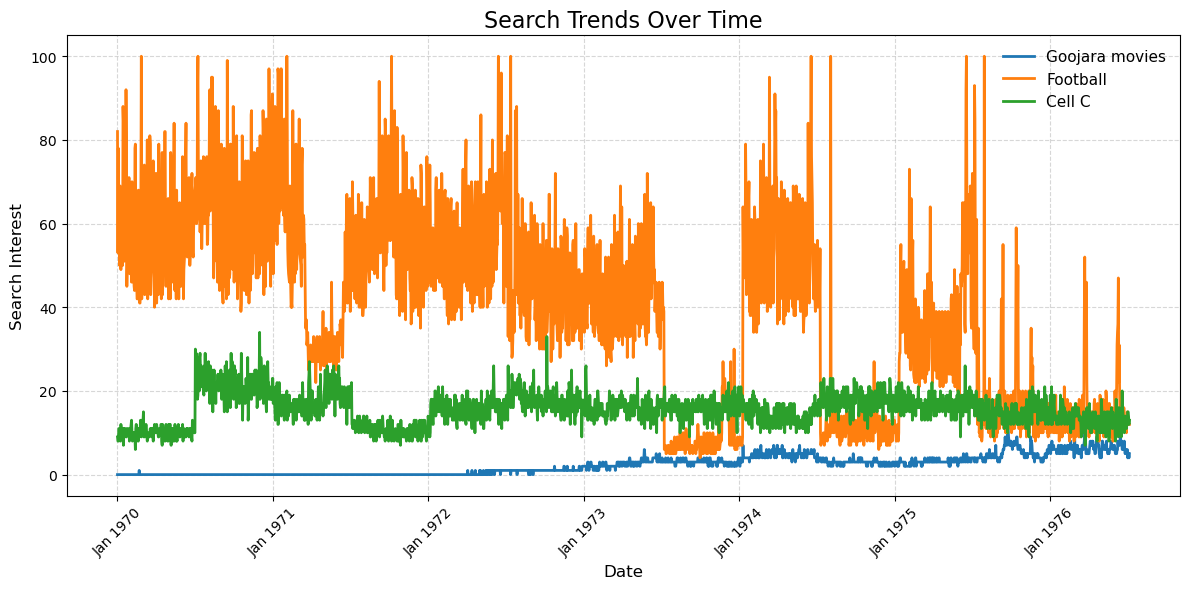

In [122]:

plt.figure(figsize=(12, 6))

plt.plot(df['date'], df['Goojara movies'], linewidth=2, label='Goojara movies')
plt.plot(df['date'], df['Football'], linewidth=2, label='Football')
plt.plot(df['date'], df['Cell C'], linewidth=2, label='Cell C')

# Styling
plt.title("Search Trends Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Search Interest", fontsize=12)

# Format x-axis to avoid clutter
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically space out dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Jul 2024', etc.

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False, fontsize=11)
plt.tight_layout()

plt.show()


# CALLING E-COMMERCE TRANSACTION DATA AND MERGE IT WITH GOGGLE TRENDS DATA

In [123]:
# Convert both to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
data['date'] = pd.to_datetime(df['date'], errors='coerce')

In [124]:
# Check exact date equality
dates_match = df['date'].equals(data['date'])
print("Do the dates match exactly?", dates_match)


Do the dates match exactly? False


In [125]:
# Find dates in df (trends) but not in data (CEIC VALUE)
missing_in_value = df[~df['date'].isin(data['date'])]

# Display missing dates
print("Dates in df (trends) but NOT in data (CEIC VALUE):")
missing_in_value['date']

Dates in df (trends) but NOT in data (CEIC VALUE):


2365   2025-06-21
2366   2025-06-22
2367   2025-06-23
2368   2025-06-24
2369   2025-06-25
2370   2025-06-26
2371   2025-06-27
2372   2025-06-28
2373   2025-06-29
2374   2025-06-30
2375   2025-07-01
2376   2025-07-02
2377   2025-07-03
2378   2025-07-04
Name: date, dtype: datetime64[ns]

In [126]:
# investigate the above mismatch

data.tail(20)

,date,E-Commerce Value,E-Commerce Volume
2345,2025-06-01,52077.098197,850
2346,2025-06-02,16731.494114,233
2347,2025-06-03,1038.469669,23
2348,2025-06-04,20296.072026,405
2349,2025-06-05,20153.182710,403
2350,2025-06-06,36906.546984,859
2351,2025-06-07,12157.231301,250
2352,2025-06-08,2845.210610,61
2353,2025-06-09,441.922691,15
2354,2025-06-10,22956.149007,490


In [127]:
# Concatenate the last 20 dates side by side
comparison = pd.concat([df['date'].tail(20).reset_index(drop=True),
                        data['date'].tail(20).reset_index(drop=True)],
                       axis=1)

# Rename columns for clarity
comparison.columns = ['df_date',    '     data_date']

# Print the result
print(comparison)


      df_date      data_date
0  2025-06-15     2025-06-01
1  2025-06-16     2025-06-02
2  2025-06-17     2025-06-03
3  2025-06-18     2025-06-04
4  2025-06-19     2025-06-05
5  2025-06-20     2025-06-06
6  2025-06-21     2025-06-07
7  2025-06-22     2025-06-08
8  2025-06-23     2025-06-09
9  2025-06-24     2025-06-10
10 2025-06-25     2025-06-11
11 2025-06-26     2025-06-12
12 2025-06-27     2025-06-13
13 2025-06-28     2025-06-14
14 2025-06-29     2025-06-15
15 2025-06-30     2025-06-16
16 2025-07-01     2025-06-17
17 2025-07-02     2025-06-18
18 2025-07-03     2025-06-19
19 2025-07-04     2025-06-20


In [128]:
# Find dates in df but not in data
dates_only_in_df = df[~df['date'].isin(data['date'])]

# Display the unique dates
print("Dates in df but NOT in data:")
print(dates_only_in_df['date'].unique())

Dates in df but NOT in data:
<DatetimeArray>
['2025-06-21 00:00:00', '2025-06-22 00:00:00', '2025-06-23 00:00:00',
 '2025-06-24 00:00:00', '2025-06-25 00:00:00', '2025-06-26 00:00:00',
 '2025-06-27 00:00:00', '2025-06-28 00:00:00', '2025-06-29 00:00:00',
 '2025-06-30 00:00:00', '2025-07-01 00:00:00', '2025-07-02 00:00:00',
 '2025-07-03 00:00:00', '2025-07-04 00:00:00']
Length: 14, dtype: datetime64[ns]


In [129]:
# Find dates in data but not in df
dates_only_in_data = data[~data['date'].isin(df['date'])]

# Display the unique dates
print("Dates in data but NOT in df:")
print(dates_only_in_data['date'].unique())

Dates in data but NOT in df:
<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


In [130]:
# Dates in df_trends but NOT in df_value
missing_in_trends = data[~data['date'].isin(df['date'])]
print("Dates in data_value but not in df_trends:")
print(missing_in_trends['date'].to_string(index=False))


Dates in data_value but not in df_trends:
Series([], )


In [131]:
# summing everything 

print(f"Missing in data_trends: {len(missing_in_trends)}")
print(f"Missing in df_value: {len(missing_in_value)}")


Missing in data_trends: 0
Missing in df_value: 14


In [ ]:

# Set 'date' as index
df = df.set_index('date')
data = data.set_index('date')

# Merge (join) on index, keeping all dates from 'data' (right join)
final_data = df.join(data, how='right', lsuffix='_df', rsuffix='_data')

# Check the result
final_data.head()

,mp3 download,YouTube,Tubidy download,Netflix,Goojara movies,Netnaija movies,Disney+,canvas prints,digital art,We Buy Cars,...,Lodging,Flight,Hotel,Guest House,Booking,FlySafair,Lift Airline,Car Rental,E-Commerce Value,E-Commerce Volume
date,,,,,,,,,,,,,,,,,,,,,
2018-12-30,80,59,6,18,0,0,39,0,0,7,...,0,63,100,37,22,7,0,9,48229.459312,456
2018-12-31,91,73,8,15,0,0,21,0,0,5,...,0,57,98,36,23,8,0,12,68629.143788,559
2019-01-01,76,59,6,24,0,0,36,0,0,9,...,0,73,92,27,31,8,0,8,52162.890120,471
2019-01-02,65,57,5,17,0,0,32,0,0,11,...,0,64,89,28,27,9,0,8,66311.844346,736
2019-01-03,58,56,5,14,0,0,23,0,0,13,...,0,56,94,25,28,8,0,11,95740.128026,682


In [133]:
final_data.tail()

,mp3 download,YouTube,Tubidy download,Netflix,Goojara movies,Netnaija movies,Disney+,canvas prints,digital art,We Buy Cars,...,Lodging,Flight,Hotel,Guest House,Booking,FlySafair,Lift Airline,Car Rental,E-Commerce Value,E-Commerce Volume
date,,,,,,,,,,,,,,,,,,,,,
2025-06-16,55,88,17,25,8,19,66,0,0,37,...,0,40,71,24,19,9,0,17,28205.582890,629
2025-06-17,45,87,14,19,6,18,56,0,0,38,...,0,38,54,26,29,13,0,21,29144.454690,624
2025-06-18,45,84,13,16,6,21,52,0,0,40,...,0,29,56,24,27,10,0,14,40365.723218,1077
2025-06-19,46,85,15,17,6,24,51,0,0,36,...,0,38,57,24,23,8,0,18,21466.979056,484
2025-06-20,55,77,16,20,7,21,68,0,0,35,...,0,34,60,21,20,8,0,18,13976.384070,295


In [134]:
final_data.shape

(2365, 166)

In [135]:
final_data.isna().sum().sum()

736

In [136]:
print(final_data.columns.tolist())

['mp3 download', 'YouTube', 'Tubidy download', 'Netflix', 'Goojara movies', 'Netnaija movies', 'Disney+', 'canvas prints', 'digital art', 'We Buy Cars', 'AutoTrader', 'Toyota', 'BMW', 'Mercedes Benz', 'Cars for Sale', 'Hyundai', 'Volkswagen Polo', 'Cars', 'Renault Kiger', 'Clicks', 'Dischem', 'Avon', 'CeraVe', 'Perfume', 'Hair', 'Makeup', 'Cosmetics', 'Beauty Salon', 'Exclusive Books', 'Download', 'Wattpad', 'textbook', 'ebook', 'poetry', 'Amazon books', 'novel', 'Hollywoodbets', 'The Courier Guy', 'ShopRite', 'Steers', 'Betway', 'Buffalo Logistics', 'Uber Eats', 'Bolt', '60 sixty', 'PaymeNow', 'DStv Stream', 'Download.1', 'Mr Price', 'Makro', 'Microsoft', 'Apple', 'Samsung', 'computer', 'laptop', 'monitor stand', 'Online banking', 'Capitec Bank', 'Standard Bank', 'FNB (First National Bank)', 'Nedbank', 'Loan', 'Investment app', 'trading platforms', 'mutual funds', 'stocks', 'KFC', 'beverage', 'McDonalds', 'Checkers', 'Woolworths', 'Pick n Pay', 'Nandos', 'Burger King', 'Debonairs Pizz

In [137]:
# Columns with missing values
missing_columns = final_data.columns[final_data.isna().any()]
print("Columns with missing values:")
print(missing_columns.tolist())

Columns with missing values:
['magazines', 'news subscription']


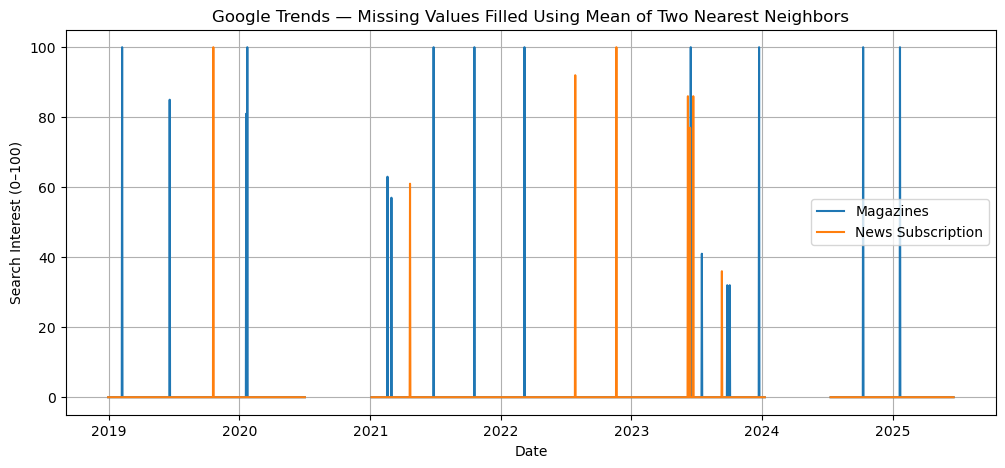

In [139]:

# --- visualization ---
plt.figure(figsize=(12, 5))
plt.plot(final_data.index, final_data['magazines'], label='Magazines')
plt.plot(final_data.index, final_data['news subscription'], label='News Subscription')
plt.title('Google Trends — Missing Values Filled Using Mean of Two Nearest Neighbors')
plt.xlabel('Date')
plt.ylabel('Search Interest (0–100)')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
# Compute total percentage of missing values
total_missing_percentage = (final_data.isnull().sum().sum() / (final_data.shape[0] * final_data.shape[1])) * 100

print(f"Total percentage of missing values: {total_missing_percentage:.2f}%")

# You can also get a breakdown by column
print("\nMissing values by column:")
for column in final_data.columns:
    missing_count = final_data[column].isnull().sum()
    missing_percentage = (missing_count / len(final_data)) * 100
    print(f"{column}: {missing_count} missing ({missing_percentage:.2f}%)")

Total percentage of missing values: 0.19%

Missing values by column:
mp3 download: 0 missing (0.00%)
YouTube: 0 missing (0.00%)
Tubidy download: 0 missing (0.00%)
Netflix: 0 missing (0.00%)
Goojara movies: 0 missing (0.00%)
Netnaija movies: 0 missing (0.00%)
Disney+: 0 missing (0.00%)
canvas prints: 0 missing (0.00%)
digital art: 0 missing (0.00%)
We Buy Cars: 0 missing (0.00%)
AutoTrader: 0 missing (0.00%)
Toyota: 0 missing (0.00%)
BMW: 0 missing (0.00%)
Mercedes Benz: 0 missing (0.00%)
Cars for Sale: 0 missing (0.00%)
Hyundai: 0 missing (0.00%)
Volkswagen Polo: 0 missing (0.00%)
Cars: 0 missing (0.00%)
Renault Kiger: 0 missing (0.00%)
Clicks: 0 missing (0.00%)
Dischem: 0 missing (0.00%)
Avon: 0 missing (0.00%)
CeraVe: 0 missing (0.00%)
Perfume: 0 missing (0.00%)
Hair: 0 missing (0.00%)
Makeup: 0 missing (0.00%)
Cosmetics: 0 missing (0.00%)
Beauty Salon: 0 missing (0.00%)
Exclusive Books: 0 missing (0.00%)
Download: 0 missing (0.00%)
Wattpad: 0 missing (0.00%)
textbook: 0 missing (0.0

In [141]:

# Columns to process
cols_to_fill = ['magazines', 'news subscription']

# Function: fill missing values using mean of two nearest neighbors
def fill_with_neighbor_mean(series):
    s = series.copy()
    for i in range(1, len(s) - 1):
        if pd.isna(s.iloc[i]):
            prev_val = s.iloc[i - 1]
            next_val = s.iloc[i + 1]
            # Only fill if both neighbors exist
            if not pd.isna(prev_val) and not pd.isna(next_val):
                s.iloc[i] = (prev_val + next_val) / 2
    # Handle any remaining NaN at edges
    s.fillna(method='ffill', inplace=True)
    s.fillna(method='bfill', inplace=True)
    return s

# Apply the function to each column
for col in cols_to_fill:
    final_data[col] = fill_with_neighbor_mean(final_data[col])

# Check remaining missing values
missing_values = final_data[cols_to_fill].isna().sum()
print("Remaining missing values:\n", missing_values)



Remaining missing values:
 magazines            0
news subscription    0
dtype: int64


C:\Users\mareg\AppData\Local\Temp\ipykernel_5000\2616992813.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s.fillna(method='ffill', inplace=True)
C:\Users\mareg\AppData\Local\Temp\ipykernel_5000\2616992813.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s.fillna(method='bfill', inplace=True)


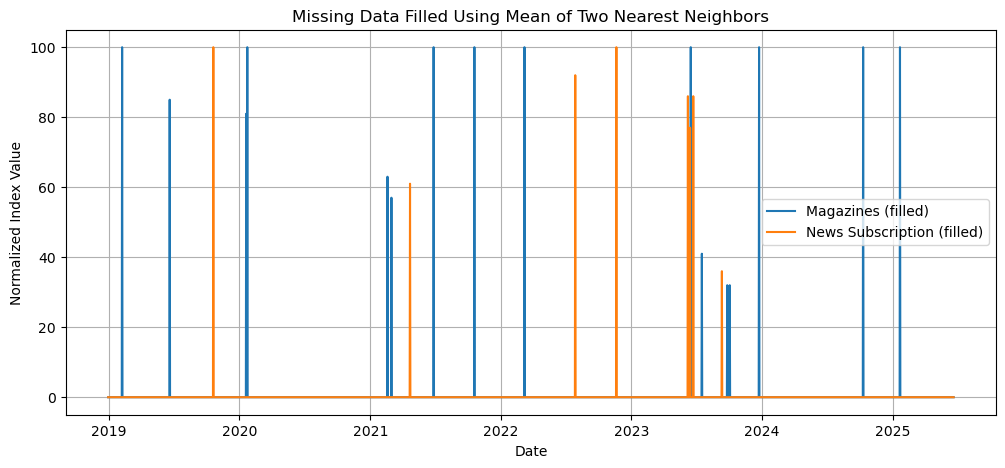

In [142]:
# --- Plot filled data for inspection ---
plt.figure(figsize=(12, 5))
plt.plot(final_data.index, final_data['magazines'], label='Magazines (filled)')
plt.plot(final_data.index, final_data['news subscription'], label='News Subscription (filled)')
plt.title('Missing Data Filled Using Mean of Two Nearest Neighbors')
plt.xlabel('Date')
plt.ylabel('Normalized Index Value')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
final_data.isna().sum().sum()

0

In [145]:
# save the final dataset
final_data.to_csv('FINAL DATASET/final_merged_trends_data.csv', index=True)